[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanpablocasado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanpablocasado/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/juanpablocasado/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


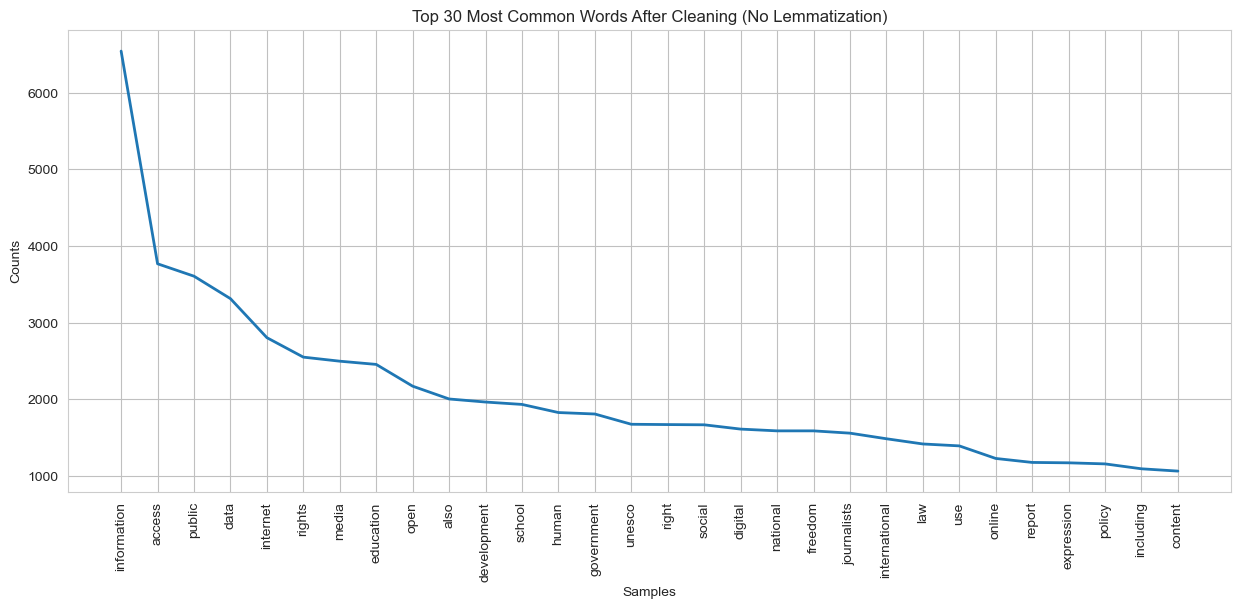

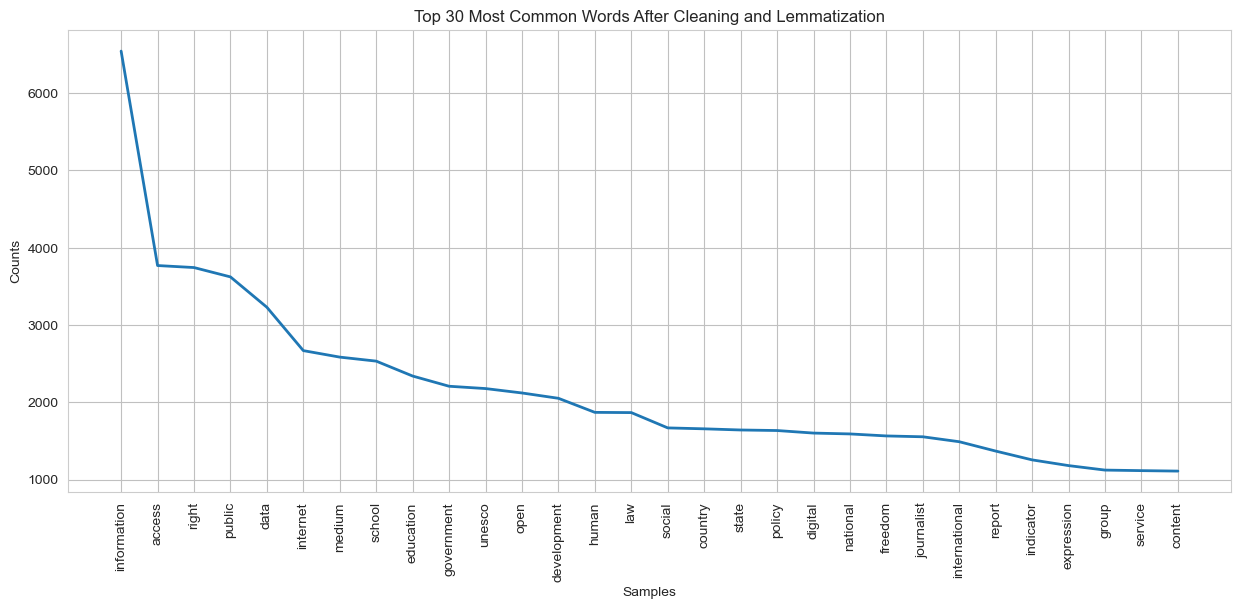

/Users/juanpablocasado/anaconda3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


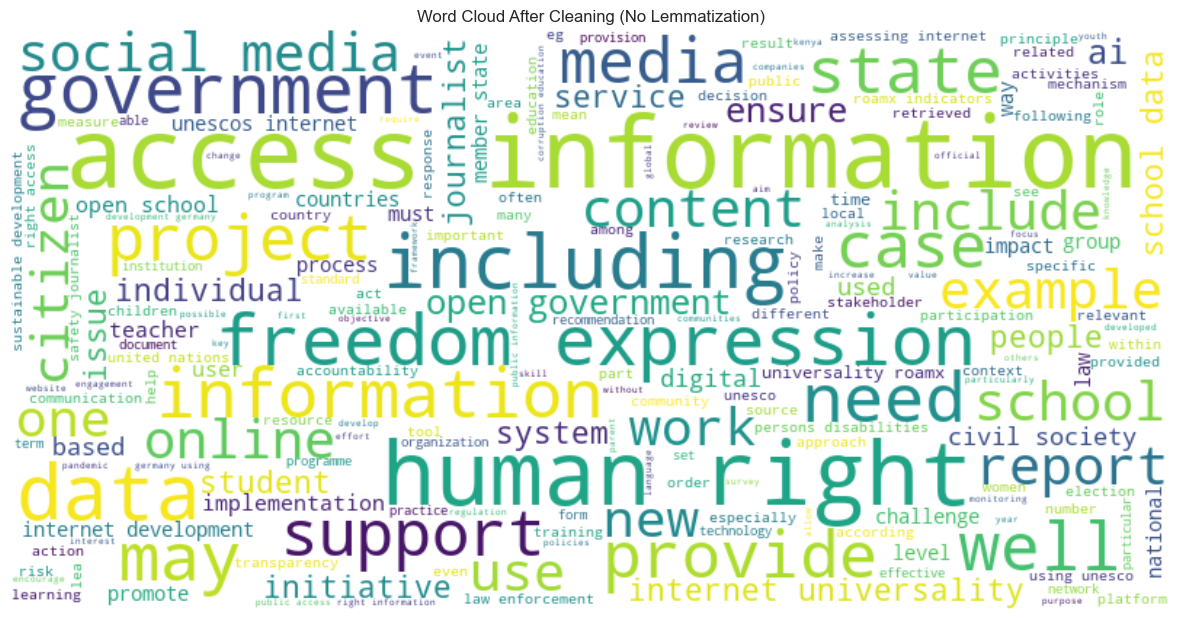

/Users/juanpablocasado/anaconda3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


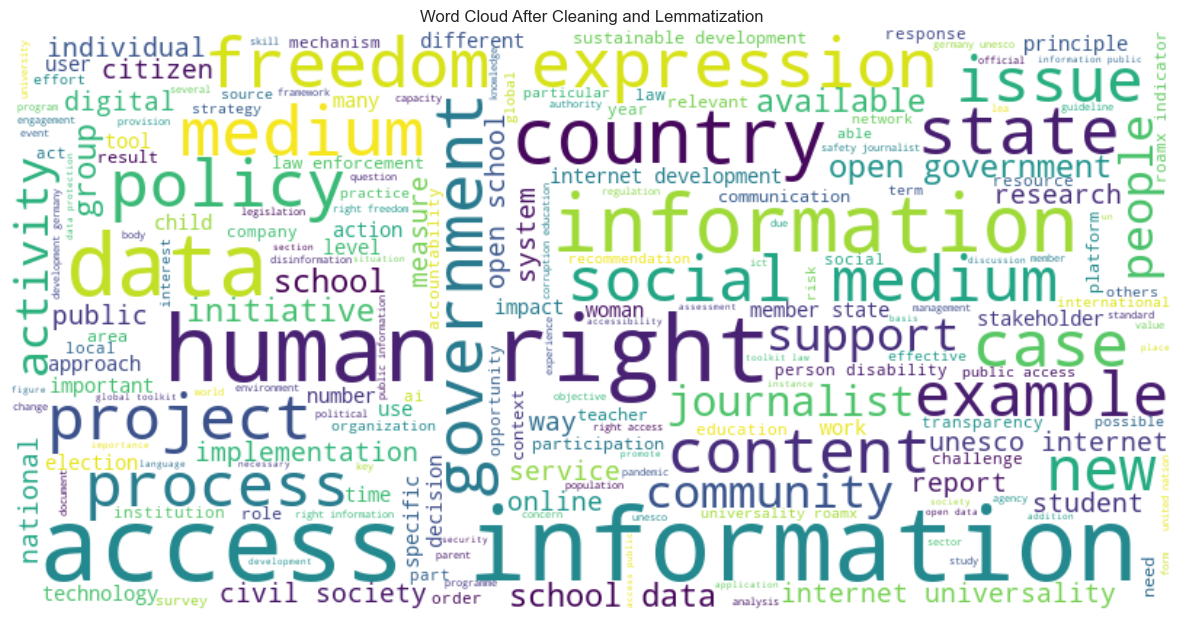

In [27]:
import os
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Setup logging
import logging

# NLTK downloads (can be excluded once downloaded)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Text Processing
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk import pos_tag
from textblob import TextBlob

# Word Cloud
from wordcloud import WordCloud

# Topic Modeling
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, Phrases, TfidfModel, CoherenceModel
import pyLDAvis.gensim_models


# Define the directory where the corpus is located
source_dir = '/Users/juanpablocasado/Downloads/OneDrive_1_7-8-2023/txt'  #Source directory of all the original documents in txt format
output_dir = '/Users/juanpablocasado/Downloads/OneDrive_1_7-8-2023/cleanedtxt'  #Output directory of all the cleaned documents in txt format


# Define the cleaning function without lemmatization
def clean_text_without_lemmatization(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Only keeping alphabets and spaces
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return words

# Define the cleaning function with lemmatization
def get_wordnet_pos(treebank_tag):
    """Map treebank POS tag to first character used by WordNetLemmatizer"""
    tag = {
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV,
        'J': wordnet.ADJ
    }.get(treebank_tag[0], wordnet.NOUN)
    return tag

def clean_text_with_lemmatization(text):
    words = clean_text_without_lemmatization(text)  # Using the tokenization from the newer script
    lemmatizer = WordNetLemmatizer()
    tagged_words = pos_tag(words)
    # Only keep nouns (starting with 'N') and adjectives (starting with 'J')
    words = [lemmatizer.lemmatize(word) for word, pos in tagged_words if pos.startswith('N') or pos.startswith('J')]
    return words

# Load and clean the corpus based on the cleaning function provided
def load_and_clean_corpus_as_documents(directory_path, cleaning_function):
    all_documents = []
    for file_name in os.listdir(directory_path):
        with open(os.path.join(directory_path, file_name), 'r', encoding='utf-8', errors='ignore') as file:
            content = file.read()
            document_words = cleaning_function(content)
            all_documents.append(document_words)
    return all_documents

# Display the word frequency distribution graph
def plot_word_frequency(words, top_n=30, title_suffix=""):
    freq_dist = FreqDist(words)
    plt.figure(figsize=(15,6))
    freq_dist.plot(top_n, title=f"Top {top_n} Most Common Words {title_suffix}")
    plt.show()

# Load and clean the corpus without lemmatization
all_words_without_lemmatization = load_and_clean_corpus(source_dir, clean_text_without_lemmatization)

# Plot the word frequency distribution for cleaned but not lemmatized text
plot_word_frequency(all_words_without_lemmatization, title_suffix="After Cleaning (No Lemmatization)")

# Load and clean the corpus with lemmatization
all_words_with_lemmatization = load_and_clean_corpus(source_dir, clean_text_with_lemmatization)

# Plot the word frequency distribution for cleaned and lemmatized text
plot_word_frequency(all_words_with_lemmatization, title_suffix="After Cleaning and Lemmatization")

# Generate and display a word cloud
def generate_word_cloud(words, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(words))
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word cloud for cleaned but not lemmatized text
generate_word_cloud(all_words_without_lemmatization, title="Word Cloud After Cleaning (No Lemmatization)")

# Generate word cloud for cleaned and lemmatized text
generate_word_cloud(all_words_with_lemmatization, title="Word Cloud After Cleaning and Lemmatization")


In [28]:
#Save the cleaned texts

for dirpath, dirnames, filenames in os.walk(source_dir):
    structure = os.path.join(output_dir, os.path.relpath(dirpath, source_dir))
    if not os.path.isdir(structure):
        os.mkdir(structure)
    for file in filenames:
        if file.endswith('.pdf'):
            pdf = PdfReader(os.path.join(dirpath, file))
            text = ''
            for page in pdf.pages:
                text += page.extract_text()
        elif file.endswith('.txt'):
            with open(os.path.join(dirpath, file), 'r', errors='ignore') as f:
                text = f.read()
        else:
            print(f"Skipping file {file} due to unknown format.")
            continue
        cleaned_text_words = clean_text_with_lemmatization(text)  # Using the lemmatization function from the first snippet
        cleaned_text = ' '.join(cleaned_text_words)
        with open(os.path.join(structure, file.rsplit('.', 1)[0] + '.txt'), 'w') as f:
            f.write(cleaned_text)


In [29]:
# LDA Model setup 

save_path = '/Users/juanpablocasado/Downloads/OneDrive_1_7-8-2023/samples'  # Define your save path at the beginning
source_dir = '/Users/juanpablocasado/Downloads/OneDrive_1_7-8-2023/cleanedtxt'  # Update with the correct path
documents = load_and_clean_corpus_as_documents(source_dir, clean_text_with_lemmatization)

lemmatizer = WordNetLemmatizer()

bigram = Phrases(documents, min_count=5)
trigram = Phrases(bigram[documents], min_count=3)
documents = [trigram[bigram[doc]] for doc in documents]
# Save the first document after bigrams and trigrams
with open(os.path.join(save_path, "sample_after_bigrams_trigrams.txt"), "w") as f:
    f.write(" ".join(documents[0]))



# Create a dictionary representation of the documents
dictionary = gensim.corpora.Dictionary(documents)

# Save Initial Dictionary
with open(os.path.join(save_path, "initial_dictionary.txt"), "w") as f:
    for k, v in dictionary.items():
        f.write(f"{k}: {v}\n")

# Filter out words that occur less than 10 documents, or more than 70% of the documents
dictionary.filter_extremes(no_below=10, no_above=0.8)

# Save Filtered Dictionary
with open(os.path.join(save_path, "filtered_dictionary.txt"), "w") as f:
    for k, v in dictionary.items():
        f.write(f"{k}: {v}\n")

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Save First Few BoW Representations
with open(os.path.join(save_path, "bow_representation.txt"), "w") as f:
    for doc_bow in corpus[:5]:  # Saving the first 5 BoW representations
        f.write(f"{doc_bow}\n")

# Invert the word-to-id mapping to get id2word
id2word = {v: k for k, v in dictionary.token2id.items()}


In [ ]:
logging.basicConfig(filename='/Users/juanpablocasado/Downloads/OneDrive_1_7-8-2023/samples/logfile.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Train the LDA model with optimized configurations
for num_topics in tqdm(range(25, 41)):  # Loop from 25 to 40 topics
    for alpha in alphas:
        for eta in etas:
            for chunksize in chunksizes:
                model = LdaModel(
                    corpus=corpus,
                    id2word=id2word,
                    chunksize=chunksize,
                    alpha=alpha,
                    eta=eta,
                    iterations=iterations,
                    num_topics=num_topics,
                    passes=passes,
                    eval_every=eval_every
                )

                # Compute c_v coherence score
                coherence_model_cv = CoherenceModel(model=model, texts=documents, dictionary=dictionary, coherence='c_v')
                coherence_cv = coherence_model_cv.get_coherence()

                # Compute u_mass coherence score (no need to store it if you just want to print it)
                coherence_model_umass = CoherenceModel(model=model, texts=documents, dictionary=dictionary, coherence='u_mass')
                coherence_umass = coherence_model_umass.get_coherence()
                
                # Printing coherence scores for the current model configuration
                print(f'Num Topics: {num_topics}, Alpha: {alpha}, Eta: {eta}, Chunksize: {chunksize}, Coherence (c_v): {coherence_cv}, Coherence (u_mass): {coherence_umass}')

                if coherence_cv > max_coherence:
                    max_coherence = coherence_cv
                    best_model = model
                    best_num_topics = num_topics

print(f'Best Model: {best_num_topics} topics, Coherence Score (c_v): {max_coherence}')


# Save the best model
best_model.save("/Users/juanpablocasado/Documents/Digital text/Digital Text (f)/best_model")


# Print the topics learned by the best model
print("Topics learned by the best LDA model:")
topics = best_model.print_topics()
for topic in topics:
    print(topic)

with open('/Users/juanpablocasado/Documents/Digital text/Digital Text (f)/topics.txt', 'w') as f:
    for topic in topics:
        f.write(str(topic) + '\n')

with open('/Users/juanpablocasado/Documents/Digital text/Digital Text (f)/topics_per_document.txt', 'w') as f:
    for idx, doc in enumerate(documents):
        doc_bow = dictionary.doc2bow(doc)
        doc_topics = best_model.get_document_topics(doc_bow)  # Use best_model
        f.write(f"Document {idx}: {doc_topics}\n")

# Compute u_mass coherence score for best model
coherence_model_umass = CoherenceModel(model=best_model, texts=documents, dictionary=dictionary, coherence='u_mass')
coherence_umass = coherence_model_umass.get_coherence()
print('Coherence Score (u_mass): ', coherence_umass)

# Compute c_v coherence score for best model
coherence_model_cv = CoherenceModel(model=best_model, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_cv = coherence_model_cv.get_coherence()
print('Coherence Score (c_v): ', coherence_cv)

print("Script completed successfully.")


In [35]:
# Replace with your actual path
save_path = "/Users/juanpablocasado/Documents/Digital text/Digital Text (f)/best_model"

# Save the best model
best_model.save(save_path)

# ... (rest of the code remains unchanged)


In [22]:
    # Visualize the topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
    vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.061241 -0.006186       1        1  15.504885
9     -0.045475 -0.019164       2        1  10.093327
6     -0.012534 -0.068141       3        1  10.038316
2      0.000574 -0.047583       4        1   9.226802
3     -0.041331 -0.034598       5        1   8.989114
13     0.066691 -0.092577       6        1   8.170626
19    -0.154600 -0.071805       7        1   6.807360
11     0.099541  0.100710       8        1   6.475231
12    -0.073279  0.000780       9        1   5.340494
16     0.012909 -0.087756      10        1   4.153247
0     -0.012011  0.185068      11        1   3.731735
5     -0.055557  0.093833      12        1   2.495015
7     -0.005168  0.033597      13        1   2.360055
17    -0.201886 -0.082808      14        1   2.236379
15    -0.056287  0.006470      15        1   1.730226
8     -0.021667  0.202539      16        1   0.946499
10     0.216081 -0.015243      17        1   0.754895
4      0.221031 -0.079705      18        1   0.733791
14     0.115336 -0.005246      19        1   0.211504
18     0.008873 -0.012182      20        1   0.000499, topic_info=             Term         Freq        Total Category  logprob  loglift
1384   journalist   798.000000   798.000000  Default  30.0000  30.0000
521        school  1273.000000  1273.000000  Default  29.0000  29.0000
314           law  1070.000000  1070.000000  Default  28.0000  28.0000
295      internet   889.000000   889.000000  Default  27.0000  27.0000
468       project   667.000000   667.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
433      platform     0.000465   379.721404  Topic20  -7.4353  -1.4042
406        others     0.000465   326.016583  Topic20  -7.4355  -1.2519
34        article     0.000464   292.331243  Topic20  -7.4373  -1.1446
263   human_right     0.000464   648.191694  Topic20  -7.4374  -1.9411
1112      company     0.000464   333.998491  Topic20  -7.4378  -1.2784

[1203 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.067191   ability
0         2  0.025843   ability
0         3  0.062023   ability
0         4  0.165394   ability
0         5  0.056854   ability
...     ...       ...       ...
1103      3  0.068178  zimbabwe
1103      4  0.068178  zimbabwe
1103      8  0.409068  zimbabwe
1103     16  0.272712  zimbabwe
1103     17  0.136356  zimbabwe

[7170 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 7, 3, 4, 14, 20, 12, 13, 17, 1, 6, 8, 18, 16, 9, 11, 5, 15, 19])

In [36]:
# Extracting dominant topic and representative text for each document
results = []

for idx, doc in enumerate(documents):
    doc_bow = dictionary.doc2bow(doc)
    doc_topics = best_model.get_document_topics(doc_bow)
    dominant_topic = max(doc_topics, key=lambda x: x[1])
    
    # Extracting a snippet (first 10 words) from the document
    snippet = " ".join(doc[:10])
    
    results.append({
        "Document Index": idx,
        "Dominant Topic": dominant_topic[0],
        "Topic Probability": dominant_topic[1],
        "Representative Text": snippet
    })

# Creating a table (DataFrame) to display the results
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the table to a CSV file for further analysis
results_df.to_csv("/Users/juanpablocasado/Downloads/document_topics.csv", index=False)


    Document Index  Dominant Topic  Topic Probability  \
0                0              25           0.617055   
1                1              31           0.986813   
2                2              28           0.447129   
3                3              29           0.312031   
4                4              21           0.284957   
5                5              20           0.599155   
6                6              19           0.504752   
7                7              26           0.358104   
8                8               6           0.982518   
9                9               0           0.031250   
10              10              20           0.807252   
11              11              14           0.232664   
12              12              29           0.260372   
13              13              24           0.997971   
14              14               6           0.352845   
15              15              15           0.554121   
16              16             

In [37]:
# Adjust display settings
pd.set_option('display.max_rows', None)

# Display the DataFrame
results_df


,Document Index,Dominant Topic,Topic Probability,Representative Text
0,0,25,0.617055,covid_education disability_case bangladesh pra...
1,1,31,0.986813,intergovernmental meeting expert category draf...
2,2,28,0.447129,cic ouncil paris september original_english di...
3,3,29,0.312031,unesco global conference february regulating d...
4,4,21,0.284957,right information time right information_time_...
5,5,20,0.599155,iiep_policy_brief_open government education pa...
6,6,19,0.504752,covid_role_judicial operator_protection_promot...
7,7,26,0.358104,disin_formation_hate_speech digital_citizenshi...
8,8,6,0.982518,cicouncil paris november original_english dist...
9,9,0,0.031250,bud edsdb


In [38]:
# Function to get sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to each document
results_df['Sentiment'] = results_df['Representative Text'].apply(get_sentiment)

# Categorize sentiment as Positive, Neutral, or Negative
def categorize_sentiment(score):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"

results_df['Sentiment Category'] = results_df['Sentiment'].apply(categorize_sentiment)

# Adjust display settings
pd.set_option('display.max_rows', None)

# Display the DataFrame
results_df


,Document Index,Dominant Topic,Topic Probability,Representative Text,Sentiment,Sentiment Category
0,0,25,0.617055,covid_education disability_case bangladesh pra...,0.000000,Neutral
1,1,31,0.986813,intergovernmental meeting expert category draf...,0.000000,Neutral
2,2,28,0.447129,cic ouncil paris september original_english di...,0.000000,Neutral
3,3,29,0.312031,unesco global conference february regulating d...,0.000000,Neutral
4,4,21,0.284957,right information time right information_time_...,0.285714,Positive
5,5,20,0.599155,iiep_policy_brief_open government education pa...,0.000000,Neutral
6,6,19,0.504752,covid_role_judicial operator_protection_promot...,0.000000,Neutral
7,7,26,0.358104,disin_formation_hate_speech digital_citizenshi...,0.375000,Positive
8,8,6,0.982518,cicouncil paris november original_english dist...,0.000000,Neutral
9,9,0,0.031250,bud edsdb,0.000000,Neutral


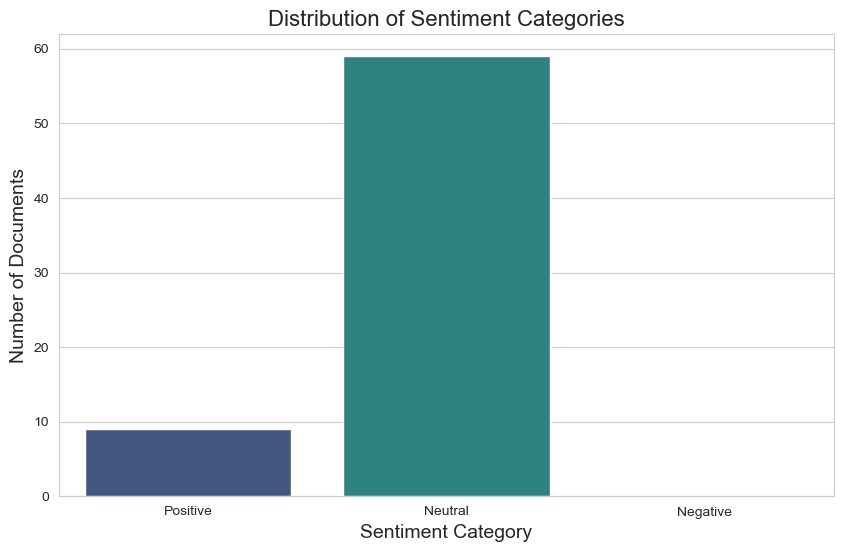

In [39]:
# Set the visual style for the plot
sns.set_style("whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment Category', data=results_df, order=['Positive', 'Neutral', 'Negative'], palette='viridis')

# Set the title and labels
plt.title('Distribution of Sentiment Categories', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=14)
plt.ylabel('Number of Documents', fontsize=14)

# Display the plot
plt.show()